<a href="https://colab.research.google.com/github/pe8sutd/DSL2025/blob/main/Verilog_HDL_Block_Clock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


# Verilog Block - Clock

## Clock Divider

1. Clock signal in a typical testbench is shown below. The clock signal has a period of 10 time units, where at each 5 time unit the clock signal toggles from 0 to 1, or 1 to 0.

```
initial clock = 0;
always #5 clock = ~clock; //generate a clock, period T=10
```

Thus, clock period, $T = \frac{t}{2}$


In [4]:
%%verilog

module tb;
  reg clock;

initial clock = 0;
always #5 clock = ~clock; //generate a clock, period T=10

initial begin
  $dumpfile("tb.vcd");
  $dumpvars;
  #21 $finish;
  $dumpoff;
end

endmodule

VCD info: dumpfile tb.vcd opened for output.



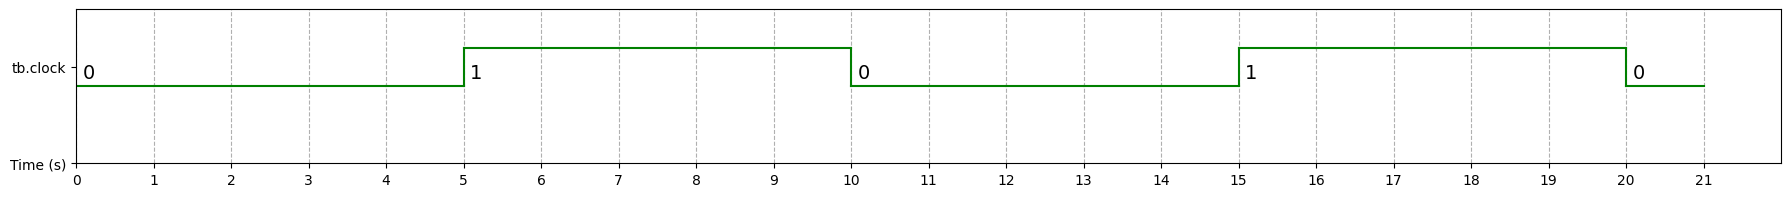

In [5]:
%%waveform tb.vcd
sign_list = ['tb.clock']
time_begin = 0
time_end = 21
base = 'bin' # bin, dec, dec2, hex, octal

The above clock generation is only for quick illustration. A more practical approach that using *forever* is commonly used for generate clock signal.

In [6]:
%%verilog

module tb;
  reg clock;

initial
    begin: CLOCK_GENERATOR
      clock = 0;
        forever
          begin
            #5 clock = ~clock;
          end
    end

initial begin
  $dumpfile("tb.vcd");
  $dumpvars;
  #21 $finish;
  $dumpoff;
end

endmodule

VCD info: dumpfile tb.vcd opened for output.



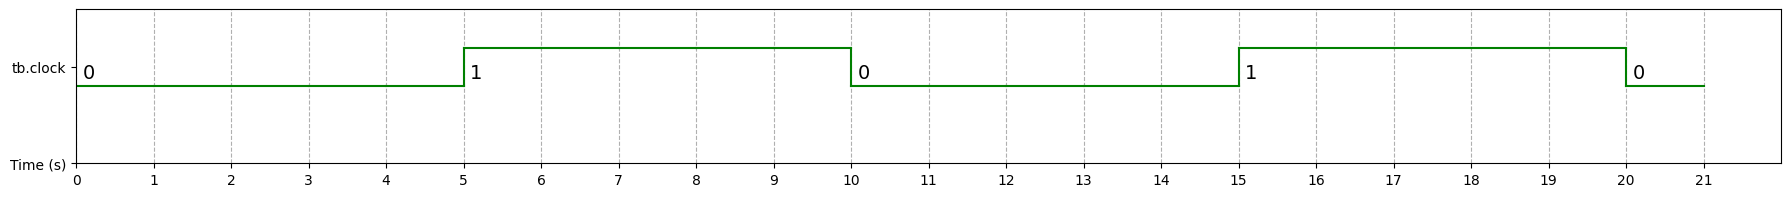

In [7]:
%%waveform tb.vcd
sign_list = ['tb.clock']
time_begin = 0
time_end = 21
base = 'bin' # bin, dec, dec2, hex, octal

To generate a clock signal in the module, the following steps are considered.  

How to generate a delay of #5 to activate the toggle will decide the clock period.

For example, assume the main clock source is at frequncy = 100 MHz, period = 10 ns.

$ t_{main\_clock} = \frac{1}{f_{main\_clock}} $

$ t_{main\_clock} = \frac{1}{100 MHz} = 10 ns $

The FPGA board provides a clock of 100 MHz, which the period is 10 ns. For the below-derived clock, which is derived from main_clock, the period is 20 ns. The clock signal toggles at every 10 ns, which is the period of the main_clock.


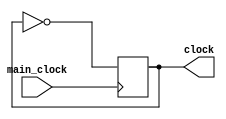

In [10]:
%%print_verilog

//
module c20ns(clock,main_clock);
 output clock;
 input main_clock; //100 MHz clock
 reg clock=1'b0;

 always @ (posedge main_clock)
  clock <= ~clock;

endmodule

As shown in the output circuit diagram of the clock generator, a Flip-Flop is introduced. This circuit is also called Clock Divider, one of the most commonly used block.

In [12]:
%%verilog

//
module c20ns(clock,main_clock);
 output clock;
 input main_clock; //100 MHz clock
 reg clock=1'b0;

 always @ (posedge main_clock)
  clock <= ~clock;

endmodule

//
`timescale 1ns/1ns

module c20ns_tb;
 wire clock;
 reg main_clock; //100 MHz clock source

c20ns c20ns1(clock,main_clock);

initial main_clock=0; always #5 main_clock=~main_clock;

initial begin
  $dumpfile("c20ns.vcd");
  $dumpvars(0,c20ns_tb);

  #55 $finish;

  $dumpoff;

 end

endmodule


VCD info: dumpfile c20ns.vcd opened for output.



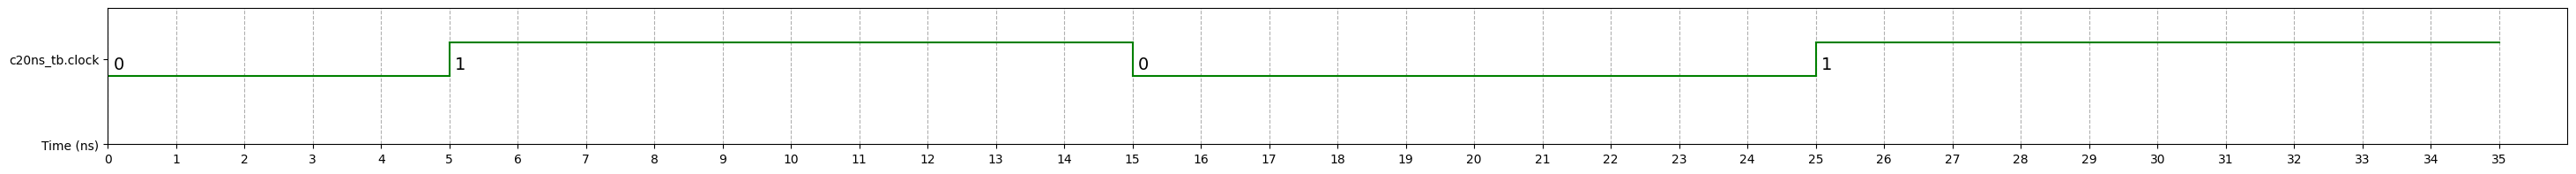

In [13]:
%%waveform c20ns.vcd
sign_list = ['c20ns_tb.clock']
time_begin = 0
time_end = 35
base = 'bin' # bin, dec, dec2, hex, octal

## Pulse Generator

The basic idea of getting a derived clock signal is to toggle the clock signal at any time of delay. How do we generate delay time from the main clock? A counter can be a block to help. The counter below gives a pulse at every 10 counts by the main_clock. (Notes: Pulse Generator is also one of the commonly used block.)

$ t_{main\_clock} = \frac{1}{f_{main\_clock}} $

$ t_{main\_clock} = \frac{1}{100 MHz} = 10 ns $

Thus, the derived clock

$ t_{derived\_clodk} =  2 \cdot n \cdot t_{main\_clock} $

$ n = 10 $

$ t_{derived\_clodk} =  2 \cdot 10 \cdot 10 ns = 200 ns $

Note that count10, counts from 0, 1, 2, ... to 9, which has 10 counts. This count10 triggers the clock to toggle every 10 counts, resulting in a derived clock at 200 ns periods, as every count is 10 ns.

Notes: There are many way to generator clock. In this course, Clock Divider, and Pulse Generator are used, as those blocks are too frequentyly used.

In [16]:
%%verilog

//
module c200ns(clock,main_clock);
 output clock;
 input main_clock; //100 MHz clock source
 reg clock = 1'b0;

 reg [3:0] count = 1'b0;
 reg count10 = 1'b0;

 always @ (posedge main_clock)
  begin
   if (count == 4'd9)
    begin
     count10 <= 1'b1;
     count <= 1'b0;
    end
   else
    begin
     count10 <= 1'b0;
     count <= count + 1'b1;
    end
  end

 always @ (posedge count10)
  clock <= ~clock;

endmodule


In [17]:
%%verilog

//
module c200ns(clock,main_clock);
 output clock;
 input main_clock; //100 MHz clock source
 reg clock=1'b0;

 reg [3:0] count = 1'b0;
 reg count10 = 1'b0;

 always @ (posedge main_clock)
  begin
   if (count == 4'd9)
    begin
     count10 <= 1'b1;
     count <= 1'b0;
    end
   else
    begin
     count10 <= 1'b0;
     count <= count + 1'b1;
    end
  end

 always @ (posedge count10)
  clock <= ~clock;

endmodule

//
`timescale 1ns/1ns

module c200ns_tb;
 wire clock;
 reg main_clock; //100 MHz clock source

c200ns c200ns1(clock,main_clock);

initial main_clock=1'b0; always #5 main_clock=~main_clock;

initial begin
  $dumpfile("c200ns.vcd");
  $dumpvars(0,c200ns_tb);

  #355 $finish;

  $dumpoff;
 end

endmodule


VCD info: dumpfile c200ns.vcd opened for output.



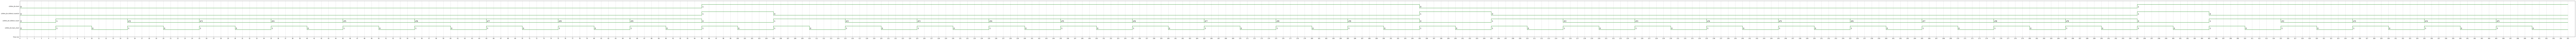

In [18]:
%%waveform c200ns.vcd
sign_list = ['c200ns_tb.clock','c200ns_tb.c200ns1.count10','c200ns_tb.c200ns1.count','c200ns_tb.main_clock']
time_begin = 0
time_end = 355
base = 'dec' # bin, dec, dec2, hex, octal

## Reset

*Reset* signal is added to the module to reset the signal to initial values, e.g. 0.

In [20]:
%%verilog

//
module c200ns_rst(clock,main_clock,btnR);
 output clock;
 input main_clock;  //100 MHz clock source
 input btnR;        //BTNR - RESET System;

 reg clock = 1'b0;
 reg [3:0] count = 1'b0;
 reg count10 = 1'b0;

 //Set BTNR Button as Reset Function;
 //Normally, the digital systems prefer logic low as reset rather than logic high;
 //Therefore, we declare a reset wire (rstn) which is connected to btnR with NOT gate;
 wire rstn;
 assign rstn = ~btnR;

 always @ (posedge main_clock or negedge rstn)
  begin
   if (rstn == 1'b0)
    begin
     count10 <= 4'b0000;
     count <= 1'b0;
    end
   else
   //**********************
    begin
     if (count == 4'd9)
      begin
       count10 <= 1'b1;
       count <= 1'b0;
      end
     else
      begin
       count10 <= 1'b0;
       count <= count + 1'b1;
      end
    end
   //**********************
  end

 always @ (posedge count10)
  clock <= ~clock;

endmodule

//
`timescale 1ns/1ns

module c200ns_rst_tb;
 wire clock;
 reg main_clock; //100 MHz clock source
 reg btnR;

c200ns_rst c200ns_rst1(clock,main_clock,btnR);

initial main_clock=0; always #5 main_clock=~main_clock;

initial begin
  $dumpfile("c200ns_rst.vcd");
  $dumpvars(0,c200ns_rst_tb);

  btnR=1'b0;
  #5 btnR=1'b1;
  #20 btnR=1'b0;
  #355 $finish;

  $dumpoff;
end

endmodule


VCD info: dumpfile c200ns_rst.vcd opened for output.



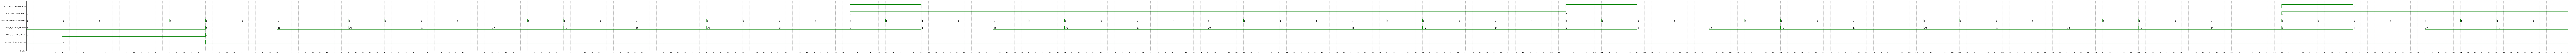

In [21]:
%%waveform c200ns_rst.vcd
sign_list = ['c200ns_rst_tb.c200ns_rst1.count10','c200ns_rst_tb.c200ns_rst1.clock','c200ns_rst_tb.c200ns_rst1.main_clock','c200ns_rst_tb.c200ns_rst1.count', 'c200ns_rst_tb.c200ns_rst1.rstn','c200ns_rst_tb.c200ns_rst1.btnR']
time_begin = 0
time_end = 355
base = 'dec' # bin, dec, dec2, hex, octal

## Parameterize

It is recommended to parameterize the design. For the below example, the derived clock,

$ t_{derived\_clodk} =  2 \cdot n \cdot t_{main\_clock} $

$ n = 12 $

$ t_{derived\_clodk} =  2 \cdot 12 \cdot 10 ns = 240 ns $

In [22]:
%%verilog

module c20Xns_rst(clock,main_clock,btnR);
 output clock;
 input main_clock;  //100 MHz clock source
 input btnR;        //BTNR - RESET System;

 //
 parameter COUNT_WIDTH = 4;
 parameter PERIOD_X = 4'd12;

 reg clock=0;
 reg [COUNT_WIDTH-1:0] count=0; //[3:0]
 reg countX=0;

 //Set BTNR Button as Reset Function;
 //Normally, the digital systems prefer logic low as reset rather than logic high;
 //Therefore, we declare a reset wire (rstn) which is connected to btnR with NOT gate;
 wire rstn;
 assign rstn=~btnR;

 always @ (posedge main_clock or negedge rstn)
  begin
   if (rstn == 1'b0)
    begin
     countX <= 0; count <= 1'b0;
    end
   else
   //**********************
    begin
     if (count == (PERIOD_X - 1'b1))
      begin
       countX <= 1'b1; count <= 1'b0;
      end
     else
      begin
       countX <= 1'b0; count <= count + 1'b1;
      end
    end
   //**********************
  end

 always @ (posedge countX)
  clock <= ~clock;

endmodule

//
`timescale 1ns/1ns

module c20Xns_rst_tb;
 wire clock;
 reg main_clock; //100 MHz clock source
 reg btnR;

c20Xns_rst c20Xns_rst1(clock,main_clock,btnR);

initial main_clock=0; always #5 main_clock=~main_clock;

initial begin
  $dumpfile("c20Xns_rst.vcd");
  $dumpvars(0,c20Xns_rst_tb);

  btnR=1'b0;
  #5 btnR=1'b1;
  #20 btnR=1'b0;
  #355 $finish;

  $dumpoff;

 end

endmodule


VCD info: dumpfile c20Xns_rst.vcd opened for output.



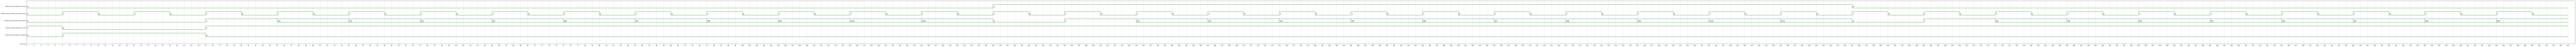

In [23]:
%%waveform c20Xns_rst.vcd
sign_list = ['c20Xns_rst_tb.c20Xns_rst1.clock','c20Xns_rst_tb.c20Xns_rst1.main_clock','c20Xns_rst_tb.c20Xns_rst1.count', 'c20Xns_rst_tb.c20Xns_rst1.rstn','c20Xns_rst_tb.c20Xns_rst1.btnR']
time_begin = 0
time_end = 355
base = 'dec' # bin, dec, dec2, hex, octal

For the handson activity, stopwatch, assumed a clock of 500 Hz, is required, from a main clock of 100 MHz.

$$t_{main\_clock} = \frac{1}{100 MHz} = 10 ns $$

$$t_{500Hz}=\frac{1}{500}=2 ms$$

$$t_{derived\_clock}=2\cdot n\cdot t_{main\_clock}$$

$$n = \frac{1}{2} \frac{t_{derived\_clock}}{t_{main\_clock}}$$

$$n = \frac{1}{2} \frac{2 ms}{10 ns} = \frac{1}{2} \frac{2 \times 10^{-3}}{10 \times 10^{-9}} = 1 \times 10^{5}$$

$$n = 100,000$$

Thus, PERIOD_X = 100, 000.

For Verilog, the number of bits must be specified also,

$$nb = ceil(log2(n))$$

$$nb = ceil(log2(100,000)) = 17$$

Thus, COUNT_WIDTH = 17.

In [24]:
import math as M

f_main_clock = 100e6;
f_derived_clock = 500;
t_main_clock = 1/f_main_clock;
t_derived_clock = 1/f_derived_clock;

n = 1/2*t_derived_clock/t_main_clock;
print('PERIOD_X =', n);

nb = M.ceil(M.log2(n));
print('COUNT_WIDTH =', nb);


PERIOD_X = 100000.0
COUNT_WIDTH = 17


In [25]:
%%verilog

//
module c20Xns_rst(clock,main_clock,btnR);
 output clock;
 input main_clock;  //100 MHz clock source
 input btnR;        //BTNR - RESET System;

 //
 parameter COUNT_WIDTH = 17;
 parameter PERIOD_X = 17'd100_000;

 reg clock=0;
 reg [COUNT_WIDTH-1:0] count=0;
 reg countX=0;

 //Set BTNR Button as Reset Function;
 //Normally, the digital systems prefer logic low as reset rather than logic high;
 //Therefore, we declare a reset wire (rstn) which is connected to btnR with NOT gate;
 wire rstn;
 assign rstn=~btnR;

 always @ (posedge main_clock or negedge rstn)
  begin
   if (rstn == 1'b0)
    begin
     countX <= 0; count <= 1'b0;
    end
   else
   //**********************
    begin
     if (count == (PERIOD_X - 1'b1))
      begin
       countX <= 1'b1; count <= 1'b0;
      end
     else
      begin
       countX <= 1'b0; count <= count + 1'b1;
      end
    end
   //**********************
  end

 always @ (posedge countX)
  clock <= ~clock;

endmodule

//
`timescale 1ns/1ns

module c20Xns_rst_tb;
 wire clock;
 reg main_clock; //100 MHz clock source
 reg btnR;

c20Xns_rst c20Xns_rst1(clock,main_clock,btnR);

initial main_clock=0; always #5 main_clock=~main_clock;

initial begin
  $dumpfile("c20Xns_rst.vcd");
  $dumpvars(0,c20Xns_rst_tb);

  btnR=1'b0;
  #5 btnR=1'b1;
  #20 btnR=1'b0;
  #355 $finish;

  $dumpoff;
 end

endmodule


VCD info: dumpfile c20Xns_rst.vcd opened for output.



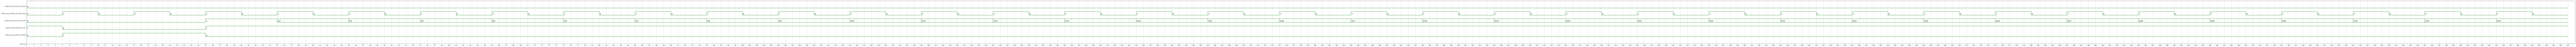

In [27]:
%%waveform c20Xns_rst.vcd
sign_list = ['c20Xns_rst_tb.c20Xns_rst1.clock','c20Xns_rst_tb.c20Xns_rst1.main_clock','c20Xns_rst_tb.c20Xns_rst1.count', 'c20Xns_rst_tb.c20Xns_rst1.rstn','c20Xns_rst_tb.c20Xns_rst1.btnR']
time_begin = 0
time_end = 355
base = 'dec' # bin, dec, dec2, hex, octal

## Modularized

It would be good to design the counter as a parameterized module that takes in the main_clock, and output countX that can be used to derive a desired clock.

In [30]:
%%verilog

//
module countY(countX,main_clock,rstn);
 output countX;
 input main_clock;  //100 MHz clock source
 input rstn;        //rstn - RESET System;

 parameter COUNT_WIDTH = 17;
 parameter PERIOD_X = 17'd100_000;

 reg clock=0;
 reg [COUNT_WIDTH-1:0] count=0;
 reg countX=0;

 always @ (posedge main_clock or negedge rstn)
  begin
   if (rstn == 1'b0)
    begin
     countX <= 0; count <= 1'b0;
    end
   else
   //**********************
    begin
     if (count == (PERIOD_X - 1'b1))
      begin
       countX <= 1'b1; count <= 1'b0;
      end
     else
      begin
       countX <= 1'b0; count <= count + 1'b1;
      end
    end
   //**********************
  end

endmodule

//
module c20Yns_rst(clock,main_clock,btnR);
 output clock;
 input main_clock;  //100 MHz clock source
 input btnR;        //BTNR - RESET System;

 reg clock=0;
 wire countX;

 wire rstn;
 assign rstn=~btnR;

 countY countY1(countX,main_clock,rstn);

 always @ (posedge countX)
  clock <= ~clock;

endmodule

//
`timescale 1ns/1ns

module c20Yns_rst_tb;
 wire clock5,clock10;
 reg main_clock; //100 MHz clock source
 reg btnR;

 defparam c20Yns_rst1.countY1.COUNT_WIDTH = 3;
 defparam c20Yns_rst1.countY1.PERIOD_X = 3'd5;

 defparam c20Yns_rst2.countY1.COUNT_WIDTH = 4;
 defparam c20Yns_rst2.countY1.PERIOD_X = 4'd10;

c20Yns_rst c20Yns_rst1(clock5,main_clock,btnR);
c20Yns_rst c20Yns_rst2(clock10,main_clock,btnR);

initial main_clock=0; always #5 main_clock=~main_clock;

initial begin
  $dumpfile("c20Yns_rst.vcd");
  $dumpvars(0,c20Yns_rst_tb);

  btnR=1'b0;
  #5 btnR=1'b1;
  #20 btnR=1'b0;
  #355 $finish;

  $dumpoff;
 end

endmodule


VCD info: dumpfile c20Yns_rst.vcd opened for output.



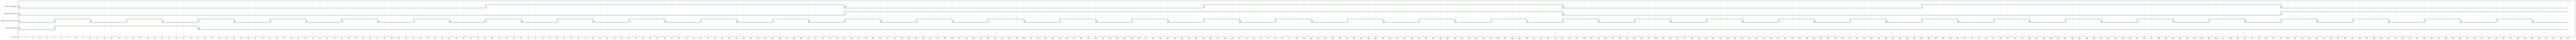

In [31]:
%%waveform c20Yns_rst.vcd
sign_list = ['c20Yns_rst_tb.clock5','c20Yns_rst_tb.clock10','c20Yns_rst_tb.main_clock','c20Yns_rst_tb.btnR']
time_begin = 0
time_end = 355
base = 'dec' # bin, dec, dec2, hex, octal

## Hierarchical design



Module c20Yns_rst can be extended to be a basic block to generate clocks.

In module countY, there are two parameters, COUNT_WIDTH, PERIOD_X, where $$COUNT\_WIDTH= ceil(log2(PERIOD\_X))$$

For example, PERIOD_X = 100, 000.
For Verilog, the number of bits must be specified also,
$$nb = ceil(log2(n))$$
$$nb = ceil(log2(100,000)) = 17$$
Thus, COUNT_WIDTH = 17.

In Verilog code, "$clog2()" is "ceil(log2())", as shown in module countXCs1.
In module countXCs1, signal count is also connected to an output port, which can be used as a clock signal.
Take note also, the port declaration method has been changed, to ease the Verilog code reading.

In [34]:
%%verilog

module countY(countX,main_clock,rstn);
 output countX;
 input main_clock;  //100 MHz clock source
 input rstn;        //rstn - RESET System;

 parameter COUNT_WIDTH = 17;
 parameter PERIOD_X = 17'd100_000;

 reg clock=0;
 reg [COUNT_WIDTH-1:0] count=0;
 reg countX=0;

 always @ (posedge main_clock or negedge rstn)
  begin
   if (rstn == 1'b0)
    begin
     countX <= 0; count <= 1'b0;
    end
   else
   //**********************
    begin
     if (count == (PERIOD_X - 1'b1))
      begin
       countX <= 1'b1; count <= 1'b0;
      end
     else
      begin
       countX <= 1'b0; count <= count + 1'b1;
      end
    end
   //**********************
  end

endmodule

//
module countXCs1
    #(  parameter PERIOD_X = 17'd100_000)
    (   output reg countX,
        output reg [$clog2(PERIOD_X)-1:0] count,
        input main_clock,   //100 MHz clock source
        input rstn          //rstn - RESET System;
    );

 always @ (posedge main_clock or negedge rstn)
  begin
   if (rstn == 1'b0)
    begin
     countX <= 1'b0; count <= 0;
    end
   else
   //**********************
    begin
     if (count == (PERIOD_X - 1'b1))
      begin
       countX <= 1'b1; count <= 0;
      end
     else
      begin
       countX <= 1'b0; count <= count + 1'b1;
      end
    end
   //**********************
  end

endmodule


Module countXCs1 is used to build up swC1_clk.

In [39]:
%%verilog

//
module countXCs1
    #(  parameter PERIOD_X = 17'd100_000)
    (   output reg countX,
        output reg [$clog2(PERIOD_X)-1:0] count,
        input main_clock,   //clock source
        input rstn          //rstn - RESET System
    );

 always @ (posedge main_clock or negedge rstn)
  begin
   if (rstn == 1'b0)
    begin
     countX <= 1'b0; count <= 0;
    end
   else
   //**********************
    begin
     if (count == (PERIOD_X - 1'b1))
      begin
       countX <= 1'b1; count <= 0;
      end
     else
      begin
       countX <= 1'b0; count <= count + 1'b1;
      end
    end
   //**********************
  end

endmodule

//
module swC1_clk
    #(parameter PERIOD_X = 17'd100_000)     //number of count
    (
    output clk_ro,                          //Output clock
    output countX,                          //
    output [$clog2(PERIOD_X)-1:0] count,    //
    input main_clock,                       //
    input rstn                              //BTNR - RESET System
    );

reg clk_r;
assign clk_ro = clk_r;
wire clk_p;
assign countX = clk_p;

//use countXCs1 module
countXCs1 countXCs11(.countX(clk_p),.count(count),.main_clock(main_clock),.rstn(rstn));

always@(posedge clk_p or negedge rstn)
    if (!rstn) clk_r <= 1'b0;
    else clk_r <= ~clk_r;   //Toggle clk reg;

endmodule


# Stopwatch Implementation

The below section demostrates how to use the above developped module to design a stopwatch. Notes: The Seven Segment Display is discussed seperately.

Module countXCs1, and swC1_clk can be used for stopwatch hierarchical design.
swC1_clk is used to generate 500 Hz, and 1 Hz clocks.
countXCs1 is used to generate Second Unit, Second Decade, Minute Unit, and Minute Decade.

### Hierarchical design

In [43]:
%%verilog

// Clock Generation
module countXCs1
    #(  parameter PERIOD_X = 17'd100_000)
    (   output reg countX,
        output reg [$clog2(PERIOD_X)-1:0] count,
        input main_clock,   //clock source
        input rstn          //rstn - RESET System
    );

 always @ (posedge main_clock or negedge rstn)
  begin
   if (rstn == 1'b0)
    begin
     countX <= 1'b0; count <= 0;
    end
   else
   //**********************
    begin
     if (count == (PERIOD_X - 1'b1))
      begin
       countX <= 1'b1; count <= 0;
      end
     else
      begin
       countX <= 1'b0; count <= count + 1'b1;
      end
    end
   //**********************
  end

endmodule
////

// Clock Generation
module swC1_clk
    #(parameter PERIOD_X = 17'd100_000)     //number of count
    (
    output clk_ro,                          //Output clock
    output countX,                          //
    output [$clog2(PERIOD_X)-1:0] count,    //
    input main_clock,                       //
    input rstn                              //BTNR - RESET System
    );

reg clk_r;
assign clk_ro = clk_r;
wire clk_p;
assign countX = clk_p;

countXCs1 countXCs11(.countX(clk_p),.count(count),.main_clock(main_clock),.rstn(rstn));

always@(posedge clk_p or negedge rstn)
    if (!rstn) clk_r <= 1'b0;
    else clk_r <= ~clk_r;   //Toggle clk reg;

endmodule
////

// Seven Segment Display
module b7num(
    output [3:0] cur_num,
    output cur_dp,
    input [15:0] bcd_num,
    input [3:0] dp,
    input [3:0] an
);

reg [3:0] cur_num_r;
assign cur_num = cur_num_r;
reg cur_dp_r;
assign cur_dp = cur_dp_r;

always @(an,bcd_num) begin
    case(an)
        4'b0001: begin cur_num_r <= bcd_num[3:0];   end
        4'b0010: begin cur_num_r <= bcd_num[7:4];   end
        4'b0100: begin cur_num_r <= bcd_num[11:8];  end
        4'b1000: begin cur_num_r <= bcd_num[15:12]; end
        default: begin cur_num_r <= 4'b0000;        end
    endcase
end

always @(an,dp) begin
    case(an)
        4'b0001: begin cur_dp_r <= dp[0];   end
        4'b0010: begin cur_dp_r <= dp[1];   end
        4'b0100: begin cur_dp_r <= dp[2];   end
        4'b1000: begin cur_dp_r <= dp[3];   end
        default: begin cur_dp_r <= 1'b0;    end
    endcase
end

endmodule
////

// Seven Segment Display
module b7c(seg,cur_num_r);
 output [6:0] seg;
 input [3:0] cur_num_r;

//Drive 7Segment Display;
//There are 4 7Segment LED on the Basys 3 Board, which share segment driver;
//Hence, we have to turn on 4 7Segment LED in sequence;
reg [6:0] segment_r;
assign seg[6:0] = segment_r[6:0];   //Connnect Register(7-Segment) to Segment Pin (seg[6:0])

//Decode BCD NUM into corrosponding 7Segment Code; dp to ca
//in binary
always @(cur_num_r)
begin
    case(cur_num_r)
        4'b0000:segment_r <= 7'b1000000;    //NUM "0"
        4'b0001:segment_r <= 7'b1111001;    //NUM "1"
        4'b0010:segment_r <= 7'b0100100;    //NUM "2"
        4'b0011:segment_r <= 7'b0110000;    //NUM "3"
        4'b0100:segment_r <= 7'b0011001;    //NUM "4"
        4'b0101:segment_r <= 7'b0010010;    //NUM "5"
        4'b0110:segment_r <= 7'b0000010;    //NUM "6"
        4'b0111:segment_r <= 7'b1111000;    //NUM "7"
        4'b1000:segment_r <= 7'b0000000;    //NUM "8"
        4'b1001:segment_r <= 7'b0010000;    //NUM "9"
        default:segment_r <= 7'hx;
    endcase
end

endmodule
//

//Top Module for the Stop Watch
`timescale 1ns / 1ns
`define x500 17'd100_000
`define x1 8'd250

module swC1
    #(  parameter PERIOD_X_500Hz = `x500,   //17'd100_000;
        parameter PERIOD_X_1Hz = `x1        // 8'd250;
    )
    (   input clk,          //100MHz Clock Source; 10ns, 500Hz=2ms, 1Hz=1s
        input btnR,         //BTNR - RESET System;
        output [6:0] seg,   //7-Segment - Segment[6:0];
        output dp,          //7-Segment - Segment-DP;
        output [3:0] an     //7-Segment - Common Anode;
    );

//Set BTNR Button as Reset Function;
wire rstn;
assign rstn=~btnR;

////////////////////////////////////////////////////////////////////////////////////////
defparam swC1_clk_500Hz.countXCs11.PERIOD_X = `x500; //17'd100_000; //100Mhz/(500Hz*2) =  100_000(17 bits);
defparam swC1_clk_1Hz.countXCs11.PERIOD_X = `x1;     //8'd250; //500Hz/(1Hz*2) = 250 (8 bits)

//In this application, 2 clock, 1Hz (1 second count) and 500Hz (7Segment);
wire clk_500hz_r, clk_500hz_p;
wire clk_1hz_r, clk_1hz_p;
wire [$clog2(PERIOD_X_500Hz)-1:0] cnter_500hz_r;    // 100Mhz/(500Hz*2) =  100_000(17 bits);
wire [$clog2(PERIOD_X_1Hz)-1:0] cnter_1hz_r;        // 500Hz/(1Hz*2) = 250 (8 bits)

//Create 500Hz Clock from 100MHz Clock Source;
swC1_clk #(.PERIOD_X(`x500)) swC1_clk_500Hz(.clk_ro(clk_500hz_r),.countX(clk_500hz_p),.count(cnter_500hz_r),.main_clock(clk),.rstn(rstn));
//Create 1Hz Clock from 500Hz Clock Source;
swC1_clk #(.PERIOD_X(`x1)) swC1_clk_1Hz(.clk_ro(clk_1hz_r),.countX(clk_1hz_p),.count(cnter_1hz_r),.main_clock(clk_500hz_r),.rstn(rstn));
////////////////////////////////////////////////////////////////////////////////////////

////////////////////////////////////////////////////////////////////////////////////////
// Timer Section is composed with 4 BCD Number counter(Minute Decade,Minute Unit, Second Decade, Minute Unit);
wire [2:0] sec_deca_bcd_r,min_deca_bcd_r; //Register - (Minute Decade,Minute Unit, Second Decade, Second Unit);
wire [3:0] sec_unit_bcd_r,min_unit_bcd_r;
wire sec_unit_cout,sec_deca_cout,min_unit_cout,min_deca_cout; //Carry Out Signal, When 4 BCD Number counter reach upper limit, it will generate a cout signal;

//Counter           Upper Limit
//Minute Decade     5
//Minute Unit       9
//Second Decade     5
//Second Unit       9
countXCs1 #(.PERIOD_X(3'd6 )) countXCs_md(.countX(min_deca_cout),.count(min_deca_bcd_r),.main_clock(min_unit_cout),.rstn(rstn));
countXCs1 #(.PERIOD_X(4'd10)) countXCs_mu(.countX(min_unit_cout),.count(min_unit_bcd_r),.main_clock(sec_deca_cout),.rstn(rstn));
countXCs1 #(.PERIOD_X(3'd6 )) countXCs_sd(.countX(sec_deca_cout),.count(sec_deca_bcd_r),.main_clock(sec_unit_cout),.rstn(rstn));
countXCs1 #(.PERIOD_X(4'd10)) countXCs_su(.countX(sec_unit_cout),.count(sec_unit_bcd_r),.main_clock(clk_1hz_r    ),.rstn(rstn));
////////////////////////////////////////////////////////////////////////////////////////

////////////////////////////////////////////////////////////////////////////////////////
//Drive 7Segment Display;
//There are 4 7Segment LED on the Basys 3 Board, which share segment driver;
//Hence, we have to turn on 4 7Segment LED in sequence;
reg [3:0] dp_r=4'b1011;             //
wire [6:0] segment_r;               //Register - Drive 7 Segment
assign seg[6:0] = segment_r[6:0];   //Connnect Register(7-Segment) to Segment Pin (seg[6:0])
wire [3:0] cur_num_r;               //Register - BCD Number Display at this moment;
wire [15:0] bcd_num;                //Wire - 4 BCD Number;
reg [3:0] an_r;                     //Register - Drive Common Anode;
assign an = ~an_r;                  //Connnect Register(Anode) to Anode Pins with NOT Gate;
                                    //If 7Segment is Common Cathod, connect Pins without NOT Gate

//When DIG4 on, BCD Number Display at this moment is bcd_num[3:0];  (i.e Stop Watch - Second Unit)
//When DIG3 on, BCD Number Display at this moment is bcd_num[7:4];  (i.e Stop Watch - Second Decade)
//When DIG2 on, BCD Number Display at this moment is bcd_num[11:8]; (i.e Stop Watch - Minute Unit)
//When DIG1 on, BCD Number Display at this moment is bcd_num[15:12];(i.e Stop Watch - Minute Decade)
assign  bcd_num[15:12]  = {1'b0,min_deca_bcd_r}; //min_deca_bcd_r 3 bits
assign  bcd_num[11:8]   = min_unit_bcd_r;
assign  bcd_num[7:4]    = {1'b0,sec_deca_bcd_r}; //sec_deca_bcd_r 3 bits
assign  bcd_num[3:0]    = sec_unit_bcd_r;

//Decode BCD NUM into corrosponding 7Segment Code;
b7num b7num1(.cur_num(cur_num_r),.cur_dp(dp),.bcd_num(bcd_num),.dp(dp_r),.an(an_r));
b7c b7c1(.seg(segment_r[6:0]),.cur_num_r(cur_num_r));
////////////////////////////////////////////////////////////////////////////////////////

////////////////////////////////////////////////////////////////////////////////////////
//Drive 7Segment Anode;
//When an_r == 0001, DIG4 will turn on;
//When an_r == 0001, at posedge clk_500hz_r, an_r will be set to 0010(DIG3 ON);
//When an_r == 0010, at posedge clk_500hz_r, an_r will be set to 0100(DIG2 ON);
//....
//DIG4 -> DIG3 -> DIG2 -> DIG1 -> DIG4 -> DIG3 -> DIG2 -> ...;
always @(negedge rstn or posedge clk_500hz_r)begin
    if(!rstn)begin
        an_r <= 4'b0000;    //When system reset, empty all display;
    end
    else begin
        case(an_r)
        4'b0001: an_r <= 4'b0010;   //DISPLAY ON DIG3
        4'b0010: an_r <= 4'b0100;   //DISPLAY ON DIG2
        4'b0100: an_r <= 4'b1000;   //DISPLAY ON DIG1
        4'b1000: an_r <= 4'b0001;   //DISPLAY ON DIG4
        default: an_r <= 4'b0001;   //DISPLAY ON DIG4
        endcase
    end
end
////////////////////////////////////////////////////////////////////////////////////////

endmodule



### Flatten Design

In [44]:
%%verilog

`timescale 1ns / 1ps

module top_module(
    input clk,      //100MHz Clock Source;
    input btnR,     //BTNR - RESET System;
    output [6:0] seg,// 7-Segment - Segment[6:0];
    output dp,      // 7-Segment - Segment-DP;
    output [3:0] an // 7-Segment - Common Anode;
);

//Set BTNR Button as Reset Function;
//Normally, the digital systems prefer logic low as reset rather than logic high;
//Therefore, we declare a reset wire (rstn) which is connected to btnR with NOT gate;
wire rstn;
assign rstn=~btnR;

//In this application, we need 2 clock, 1Hz and 500Hz;
//500Hz - Drive 7Segment Display;
//1Hz   - Drive Stop Watch;
//Create 500Hz and 1Hz Clock Signal from input 100Mhz Clk Signal;
reg clk_500hz_r;
reg clk_1hz_r;
reg [16:0]cnter_500hz_r;    // 100Mhz/(500Hz*2) =  100_000(17 bits);
reg [7:0] cnter_1hz_r;      // 500Hz/(1Hz*2) = 250 (8 bits)

//Create 500Hz Clock from 100MHz Clock Source;
//We iterate the 100MHz clock signal 100,000 times and perform a toggle operation on the clk_500hz_r register;
always@(posedge clk, negedge rstn)begin
    if(!rstn)begin              //Non-Sync Reset
        clk_500hz_r <= 1'b0;    //Set 500hz clock as '0' to avoid any uncertain status;
        cnter_500hz_r <= 17'd0; //Clear counter
    end
    else begin
        if(cnter_500hz_r == 17'd100_000-1'b1)begin   //When counter reach 100_000
            clk_500hz_r <= ~clk_500hz_r;        //Toggle 500Hz CLk reg;
            cnter_500hz_r <= 17'd0;             //Clear counter
        end
        else
            cnter_500hz_r <= cnter_500hz_r +1'b1; //Counter
    end
end

//Create 1Hz Clock from 500Hz Clock Source;
always@(posedge clk_500hz_r, negedge rstn)begin
    if(!rstn)begin
        clk_1hz_r <= 1'b0;
        cnter_1hz_r <= 8'd0;
    end
    else begin
        if(cnter_1hz_r == 8'd250-1'b1)begin
            clk_1hz_r <= ~clk_1hz_r;
            cnter_1hz_r <= 8'd0;
        end
        else
            cnter_1hz_r <= cnter_1hz_r +1'b1;
    end
end

//Drive 7Segment Display;
//There are 4 7Segment LED on the Basys 3 Board, which share segment driver;
//Hence, we have to turn on 4 7Segment LED in sequence;
reg [7:0] segment_r;        //Register - Drive 7 Segment
assign dp =  segment_r[7];  //Connnect Register(7-Segment) to Segment Pin-DP
assign seg[6:0] = segment_r[6:0];   //Connnect Register(7-Segment) to Segment Pin (seg[6:0])
reg [3:0] cur_num_r;        //Register - BCD Number Display at this moment;
wire [15:0] bcd_num;        //Wire - 4 BCD Number;
reg [3:0] an_r;             //Register - Drive Common Anode;
assign an = ~an_r;          //Connnect Register(Anode) to Anode Pins with NOT Gate;
                            //If 7Segment is Common Cathod, connect Pins without NOT Gate

//Drive 7Segment Anode;
//When an_r == 0001, DIG4 will turn on;
//When an_r == 0001, at posedge clk_500hz_r, an_r will be set to 0010(DIG3 ON);
//When an_r == 0010, at posedge clk_500hz_r, an_r will be set to 0100(DIG2 ON);
//....
//DIG4 -> DIG3 -> DIG2 -> DIG1 -> DIG4 -> DIG3 -> DIG2 -> ...;
always @(negedge rstn,posedge clk_500hz_r)begin
    if(!rstn)begin
        an_r <= 4'b0000;    //When system reset, empty all display;
    end
    else begin
        case(an_r)
        4'b0001: an_r <= 4'b0010;   //DISPLAY ON DIG3
        4'b0010: an_r <= 4'b0100;   //DISPLAY ON DIG2
        4'b0100: an_r <= 4'b1000;   //DISPLAY ON DIG1
        default: an_r <= 4'b0001;   //DISPLAY ON DIG4
        endcase
    end
end

//When DIG4 on, BCD Number Display at this moment is bcd_num[3:0];  (i.e Stop Watch - Second Unit)
//When DIG3 on, BCD Number Display at this moment is bcd_num[7:4];  (i.e Stop Watch - Second Decade)
//When DIG2 on, BCD Number Display at this moment is bcd_num[11:8]; (i.e Stop Watch - Minute Unit)
//When DIG1 on, BCD Number Display at this moment is bcd_num[15:12];(i.e Stop Watch - Minute Decade)
always @(an_r,bcd_num)begin
    case(an_r)
        4'b0001: cur_num_r <= bcd_num[3:0];
        4'b0010: cur_num_r <= bcd_num[7:4];
        4'b0100: cur_num_r <= bcd_num[11:8];
        4'b1000: cur_num_r <= bcd_num[15:12];
        default: cur_num_r <= 4'b0;
    endcase
end

//Decode BCD NUM into corrosponding 7Segment Code;
always @(cur_num_r) begin
    case(cur_num_r)
        4'h0:segment_r <= 8'hc0;    //NUM "0"
        4'h1:segment_r <= 8'hf9;    //NUM "1"
        4'h2:segment_r <= 8'ha4;    //NUM "2"
        4'h3:segment_r <= 8'hb0;    //NUM "3"
        4'h4:segment_r <= 8'h99;    //NUM "4"
        4'h5:segment_r <= 8'h92;    //NUM "5"
        4'h6:segment_r <= 8'h82;    //NUM "6"
        4'h7:segment_r <= 8'hF8;    //NUM "7"
        4'h8:segment_r <= 8'h80;    //NUM "8"
        4'h9:segment_r <= 8'h90;    //NUM "9"
        default: segment_r <= 8'hff;
        // 4'ha:segment_r <= 8'h88;    //NUM "A" - HEX NUMBER DISPLAY
        // 4'hb:segment_r <= 8'h83;    //NUM "b"
        // 4'hc:segment_r <= 8'hc6;    //NUM "C"
        // 4'hd:segment_r <= 8'ha1;    //NUM "D"
        // 4'he:segment_r <= 8'h86;    //NUM "E"
        // 4'hf:segment_r <= 8'h8e;    //NUM "F"
    endcase
end

// Timer Section is composed with 4 BCD Number counter(Minute Decade,Minute Unit, Second Decade, Minute Unit);
reg [3:0] sec_unit_bcd_r,sec_deca_bcd_r,min_unit_bcd_r,min_deca_bcd_r; //Register - (Minute Decade,Minute Unit, Second Decade, Second Unit);
reg sec_unit_cout,sec_deca_cout,min_unit_cout; //Carry Out Signal, When 4 BCD Number counter reach upper limit, it will generate a cout signal;

//Counter           Upper Limit
//Minute Decade     5
//Minute Unit       9
//Second Decade     5
//Second Unit       9

always @(posedge clk_1hz_r or negedge rstn)begin
    if(!rstn)begin
        sec_unit_bcd_r <= 4'd0; //Clear BCD Number Counter;
        sec_unit_cout <= 1'b0;  //Clear Cout Signal;
    end
    else begin
        if(sec_unit_bcd_r == 4'h9)begin
            sec_unit_cout <= 1'b1;  //Cout generate a posedge;
            sec_unit_bcd_r <= 4'd0; //Clear BCD Number Counter;
        end
        else begin
            sec_unit_cout <= 1'b0;                      //Clear Cout Signal;
            sec_unit_bcd_r <= sec_unit_bcd_r + 1'b1; // BCD Number Counter increase by '1';
        end
    end
end

always @(posedge sec_unit_cout or negedge rstn)begin
    if(!rstn)begin
        sec_deca_bcd_r <= 4'd0;
        sec_deca_cout <= 1'b0;
    end
    else begin
        if(sec_deca_bcd_r == 4'h5)begin
            sec_deca_cout <= 1'b1;
            sec_deca_bcd_r <= 4'd0;
        end
        else begin
            sec_deca_cout <= 1'b0;
            sec_deca_bcd_r <= sec_deca_bcd_r + 1'b1;
        end
    end
end

always @(posedge sec_deca_cout or negedge rstn)begin
    if(!rstn)begin
        min_unit_bcd_r <= 4'd0;
        min_unit_cout <= 1'b0;
    end
    else begin
        if(min_unit_bcd_r == 4'h9)begin
            min_unit_cout <= 1'b1;
            min_unit_bcd_r <= 4'd0;
        end
        else begin
            min_unit_cout <= 1'b0;
            min_unit_bcd_r <= min_unit_bcd_r + 1'b1;
        end
    end
end

always @(posedge min_unit_cout or negedge rstn)begin
    if(!rstn)begin
        min_deca_bcd_r <= 4'd0;
    end
    else begin
        if(min_deca_bcd_r == 4'h5)begin
            min_deca_bcd_r <= 4'd0;
        end
        else begin
            min_deca_bcd_r <= min_deca_bcd_r + 1'b1;
        end
    end
end

//When DIG4 on, BCD Number Display at this moment is bcd_num[3:0];  (i.e Stop Watch - Second Unit)
//When DIG3 on, BCD Number Display at this moment is bcd_num[7:4];  (i.e Stop Watch - Second Decade)
//When DIG2 on, BCD Number Display at this moment is bcd_num[11:8]; (i.e Stop Watch - Minute Unit)
//When DIG1 on, BCD Number Display at this moment is bcd_num[15:12];(i.e Stop Watch - Minute Decade)
assign  bcd_num[15:12]  = min_deca_bcd_r;
assign  bcd_num[11:8]   = min_unit_bcd_r;
assign  bcd_num[7:4]    = sec_deca_bcd_r;
assign  bcd_num[3:0]    = sec_unit_bcd_r;

endmodule